# Paper Abstracts Clustering - 2nd Set of Papers

Author: Rafael Ballestiero

In [1]:
import os

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

plt.rcParams['figure.figsize']=[50,30]
plt.rcParams['font.size']=22
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 24

In [259]:
from gensim import corpora

from gensim.models.phrases import Phrases
from gensim.models import LdaMulticore, KeyedVectors

from gensim.utils import has_pattern, simple_preprocess
from gensim.parsing import preprocessing
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, \
                                         strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short, stem_text

from gensim.similarities import WmdSimilarity, MatrixSimilarity
from gensim.summarization import keywords, summarize_corpus, summarize, mz_entropy
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import get_tmpfile

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

from scipy import spatial
import scipy.cluster.hierarchy as shc

import pattern.en as en

assert has_pattern()

## Clean Dataset

Construct preprocessed abstracts with custom filters.

In [402]:
df = pd.read_csv("./data/text_allyears.csv", header=0, index_col=0).dropna(subset=["Abstract"])

In [357]:
abbreviations = ["pss"]
def lemmatize(s):
    return " ".join([en.lemma(w) if w not in abbreviations else w for w in s.split()])

cp1252_pattern = re.compile(u"“|”|’|‘|—|\?")
def strip_cp1252_punctuation(s):
    return re.sub(cp1252_pattern, " ", s)

first_exclusion_common_terms = ["service", "innovation", "design", "customer", "services", "research", "study", "paper"]
second_exclusion_common_terms = ["service", "services", "research", "study", "paper", "result", "based", "literature", "article", "focus"]
def remove_common_terms(s):
    return " ".join([w for w in s.split() if w not in second_exclusion_common_terms])

In [358]:
preprocessed_abstracts = df["Abstract"].apply(str).apply(preprocess_string, filters=[
    lambda x: x.lower(),
    strip_tags,
    strip_cp1252_punctuation,
    strip_punctuation, 
    strip_multiple_whitespaces, 
    strip_numeric, 
    remove_stopwords, 
    strip_short,
    lemmatize,
    remove_common_terms
]).reset_index(drop=True)

## Vectorize Abstracts and Calculate Distances

In [266]:
def convert_glove_2_w2v():
    tmp_file = get_tmpfile("test_word2vec.txt")

    glove2word2vec("./data/glove.6B/glove.6B.50d.txt", tmp_file)

    return KeyedVectors.load_word2vec_format(tmp_file)
    
# model = convert_glove_2_w2v()

In [ ]:
def calculate_distance_matrix():
    s = preprocessed_abstracts.size
    result = np.ndarray((s,s))
    
    for i, a1 in enumerate(preprocessed_abstracts):
        print(f"({i}/{s}) Calculating distance for abstract...")
        for j, a2 in enumerate(preprocessed_abstracts.iloc[i:]):
            distance = model.wmdistance(a1, a2)
            result[i][i + j] = distance
            result[i + j][i] = distance
            print(f"D_({i}, {i + j})={distance}")
            
    return result

# abstract_distance_matrix = calculate_distance_matrix()

In [4]:
# store distance matrix
# pd.DataFrame(abstract_distance_matrix).to_csv('data/second_exclusion_distance_matrix.csv')
# load distance matrix from memory
abstract_distance_matrix = pd.read_csv('data/second_exclusion_distance_matrix.csv', index_col=0).values
# create the squareform
abstract_df = spatial.distance.squareform(abstract_distance_matrix)

## Cluster Abstracts

In [328]:
def cluster(X, n_clusters):
    return shc.fcluster(shc.linkage(X, method='ward'), n_clusters, criterion='maxclust')

### Dendogram

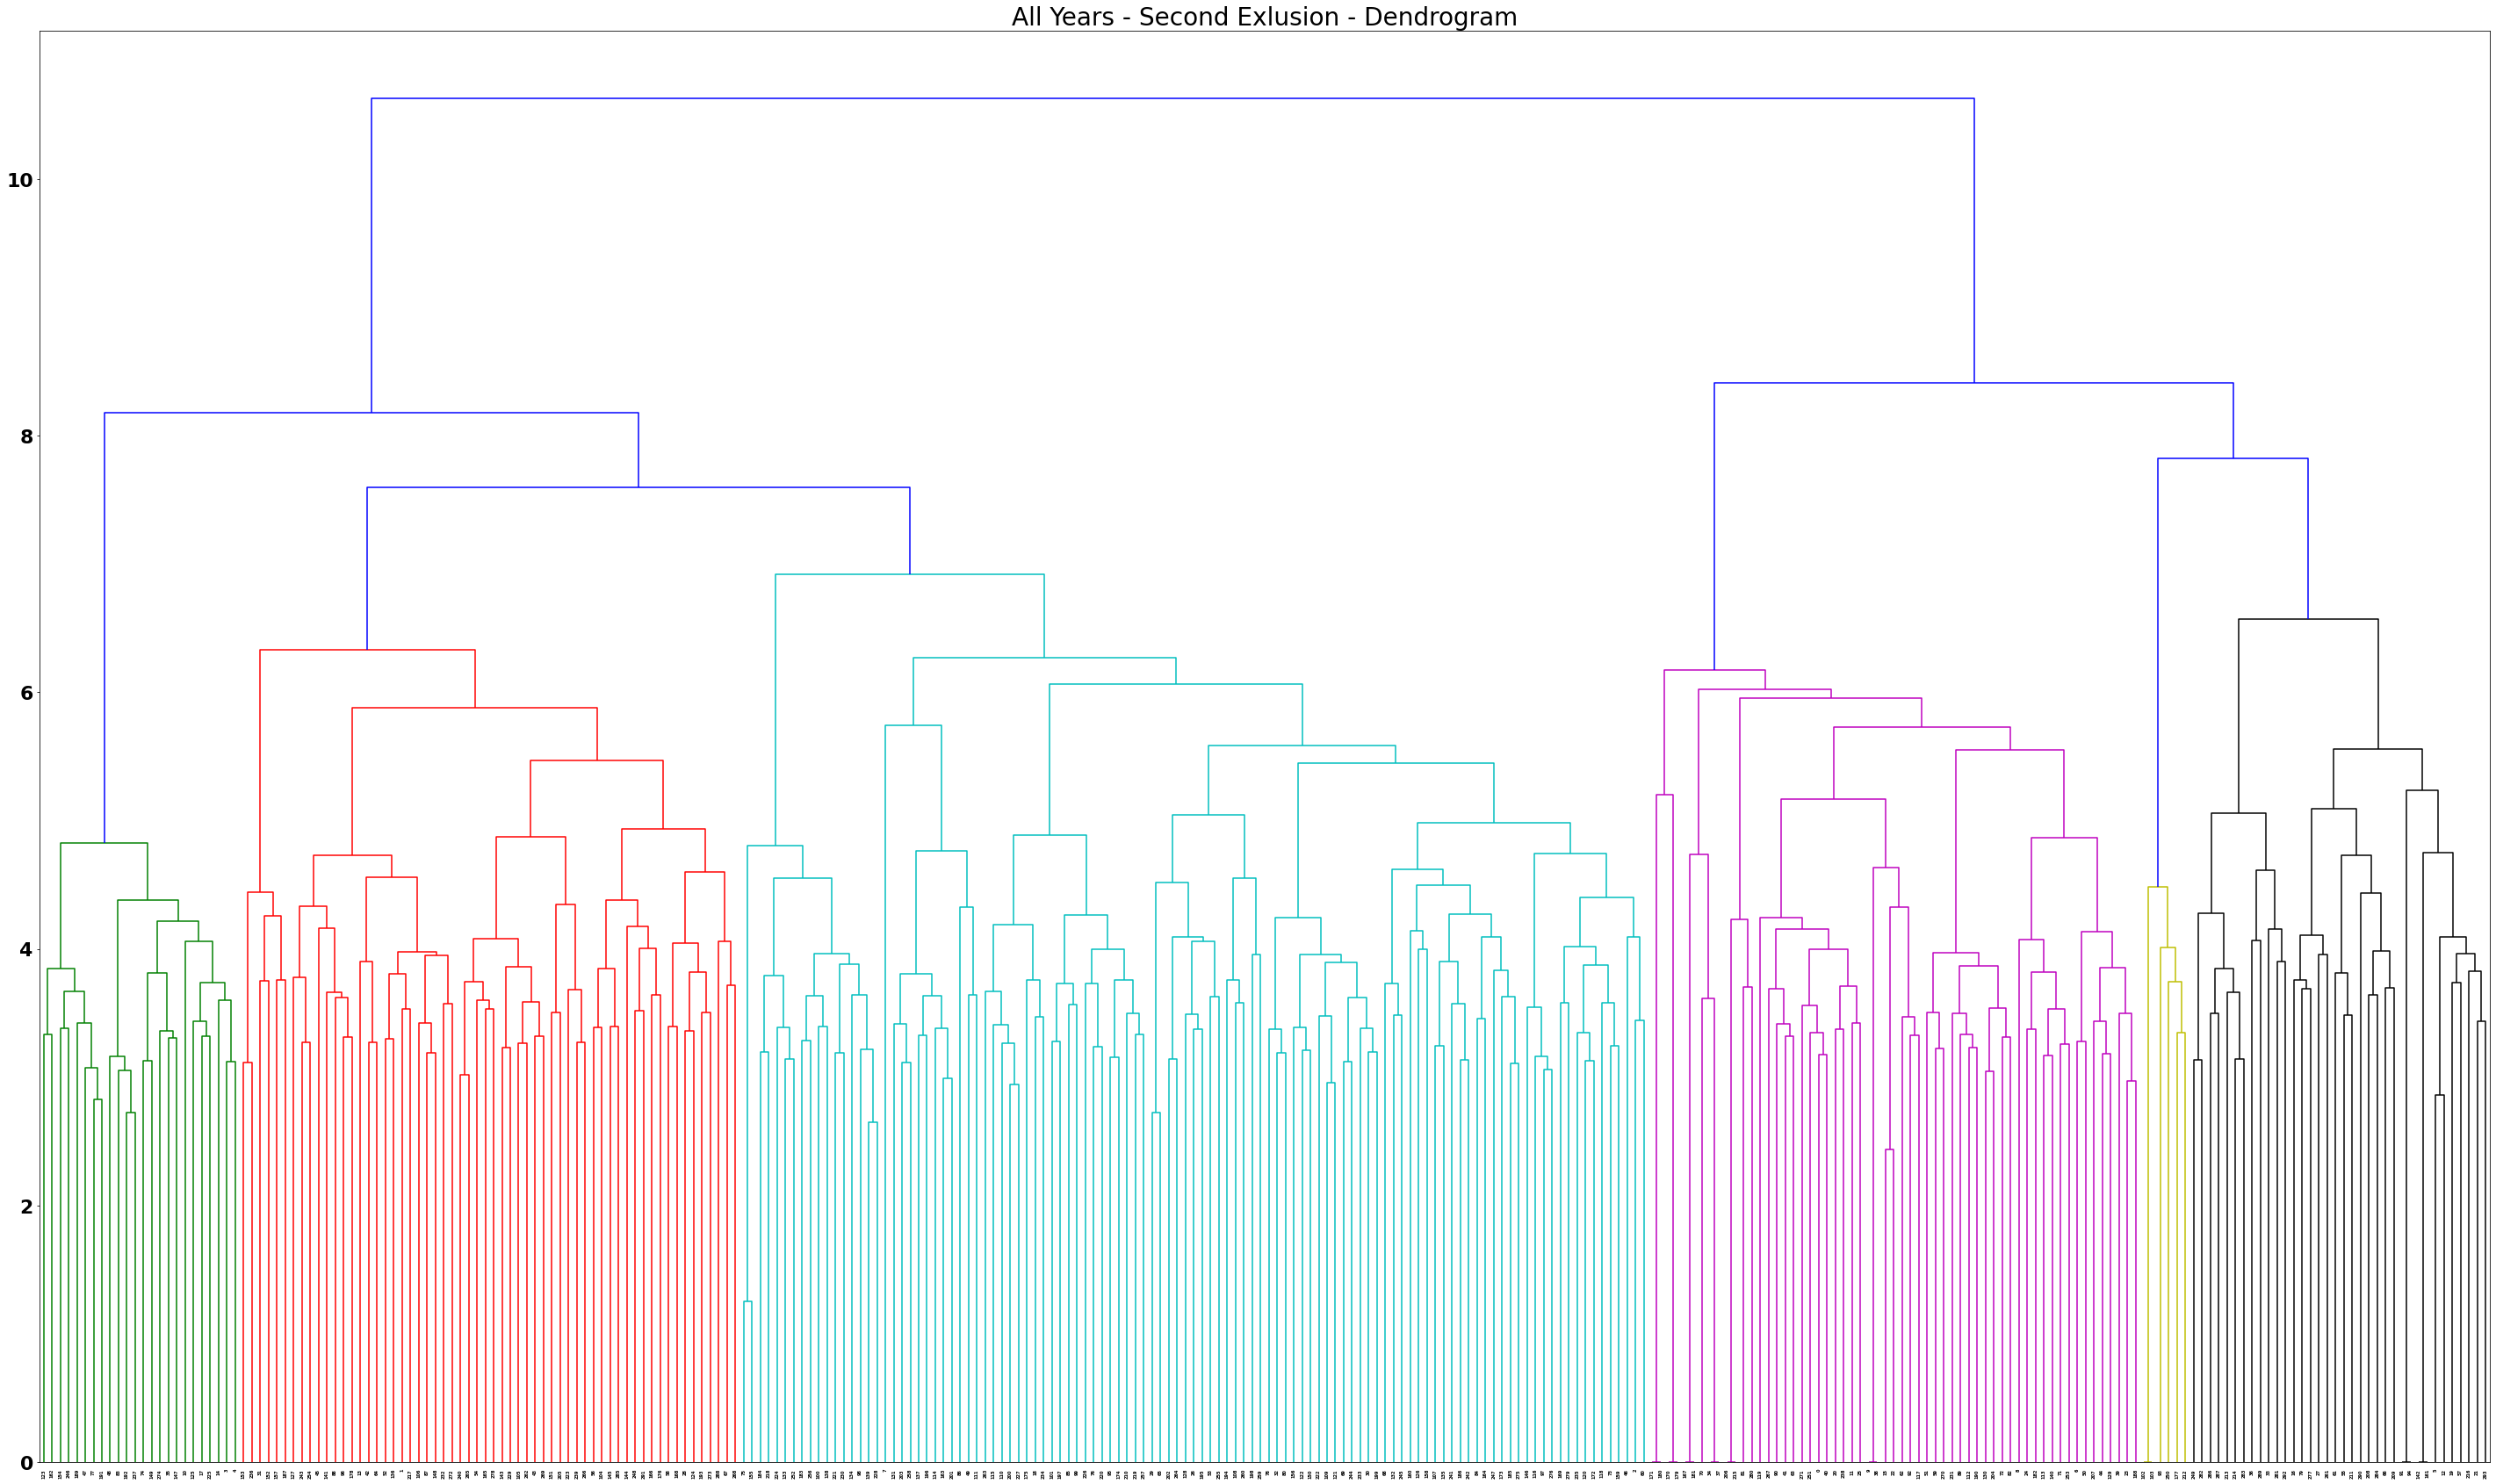

In [5]:
plt.title("All Years - Second Exlusion - Dendrogram")
dend = shc.dendrogram(shc.linkage(abstract_df, method='ward'))
plt.savefig('plots/second_exclusion/dendrogram.pdf', format='pdf')

### Silhouette Plots

In [63]:
def silhouette_evaluation(X, n_clusters, name, squareform=False):
    fig, ax1 = plt.subplots(figsize=(30, 15))

    clusters = cluster(X, n_clusters)
    
    if squareform:
        X = spatial.distance.squareform(X)

    silhouette_avg = silhouette_score(X, clusters, sample_size=None)
    samples = silhouette_samples(X, clusters)

    y_lower = 10
    for i in range(1, n_clusters + 1):
        cluster_silhouette_scores = samples[clusters == i]
        cluster_silhouette_scores.sort()

        cluster_size = cluster_silhouette_scores.shape[0]
        y_upper = y_lower + cluster_size

        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_scores)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * cluster_size, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title(f'Silhouette Graph (k={n_clusters}) - {name}')

    ax1.set_yticks([])
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.text(silhouette_avg + 0.01,20,f'silhouette_avg={np.round(silhouette_avg, 4)}')
    plt.savefig(f'plots/{name}/silhouette_{n_clusters}')
    plt.show()

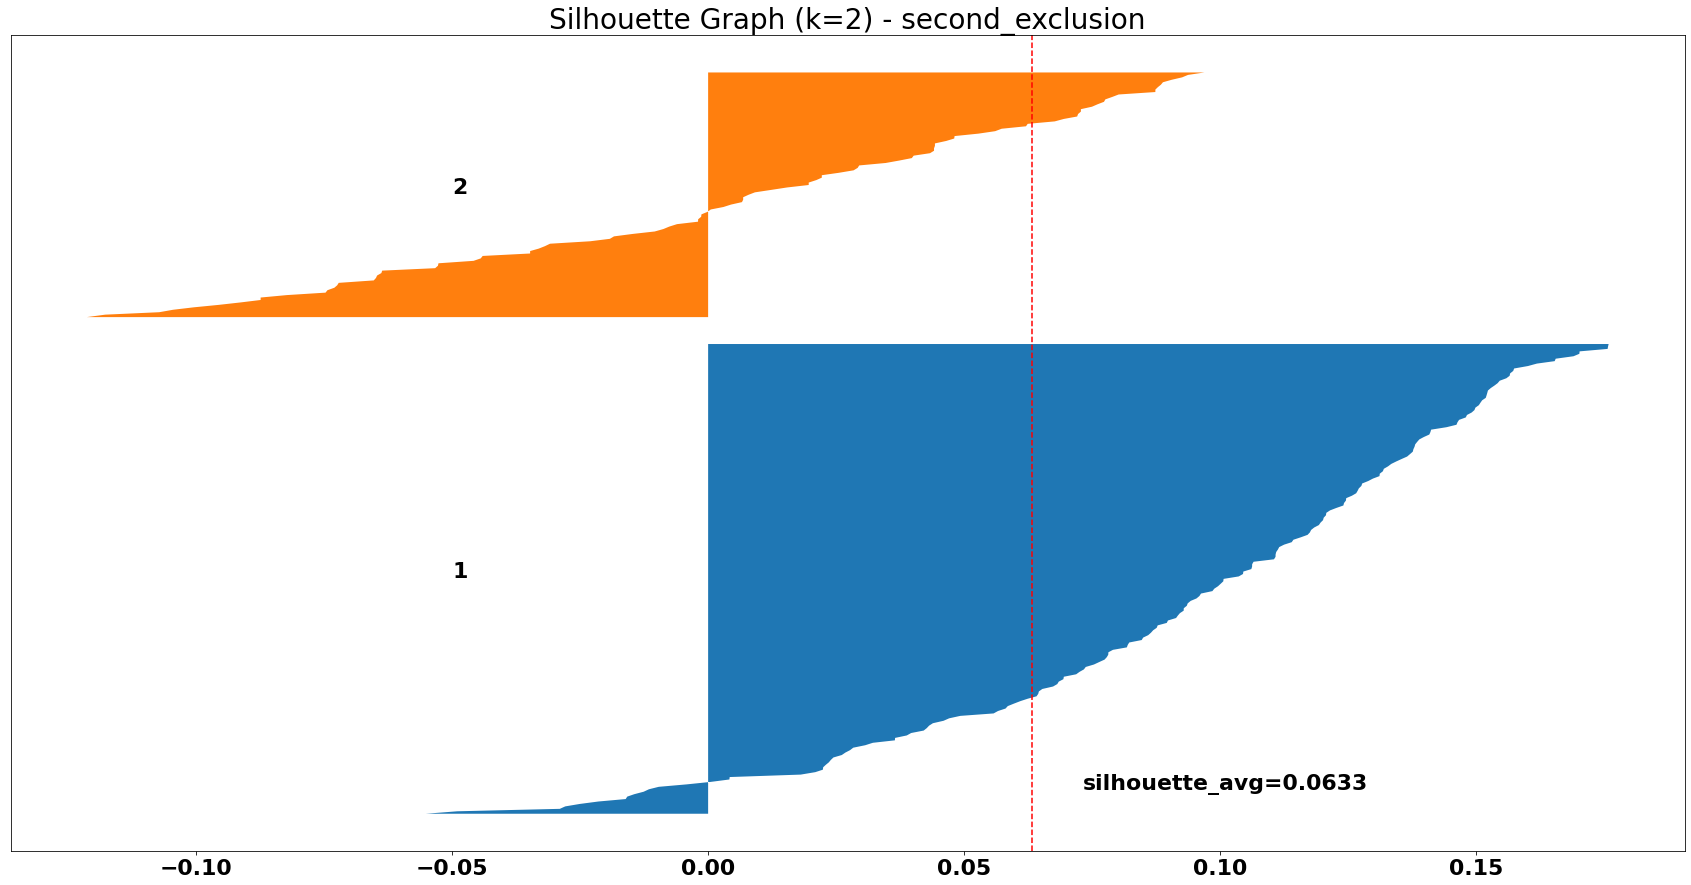

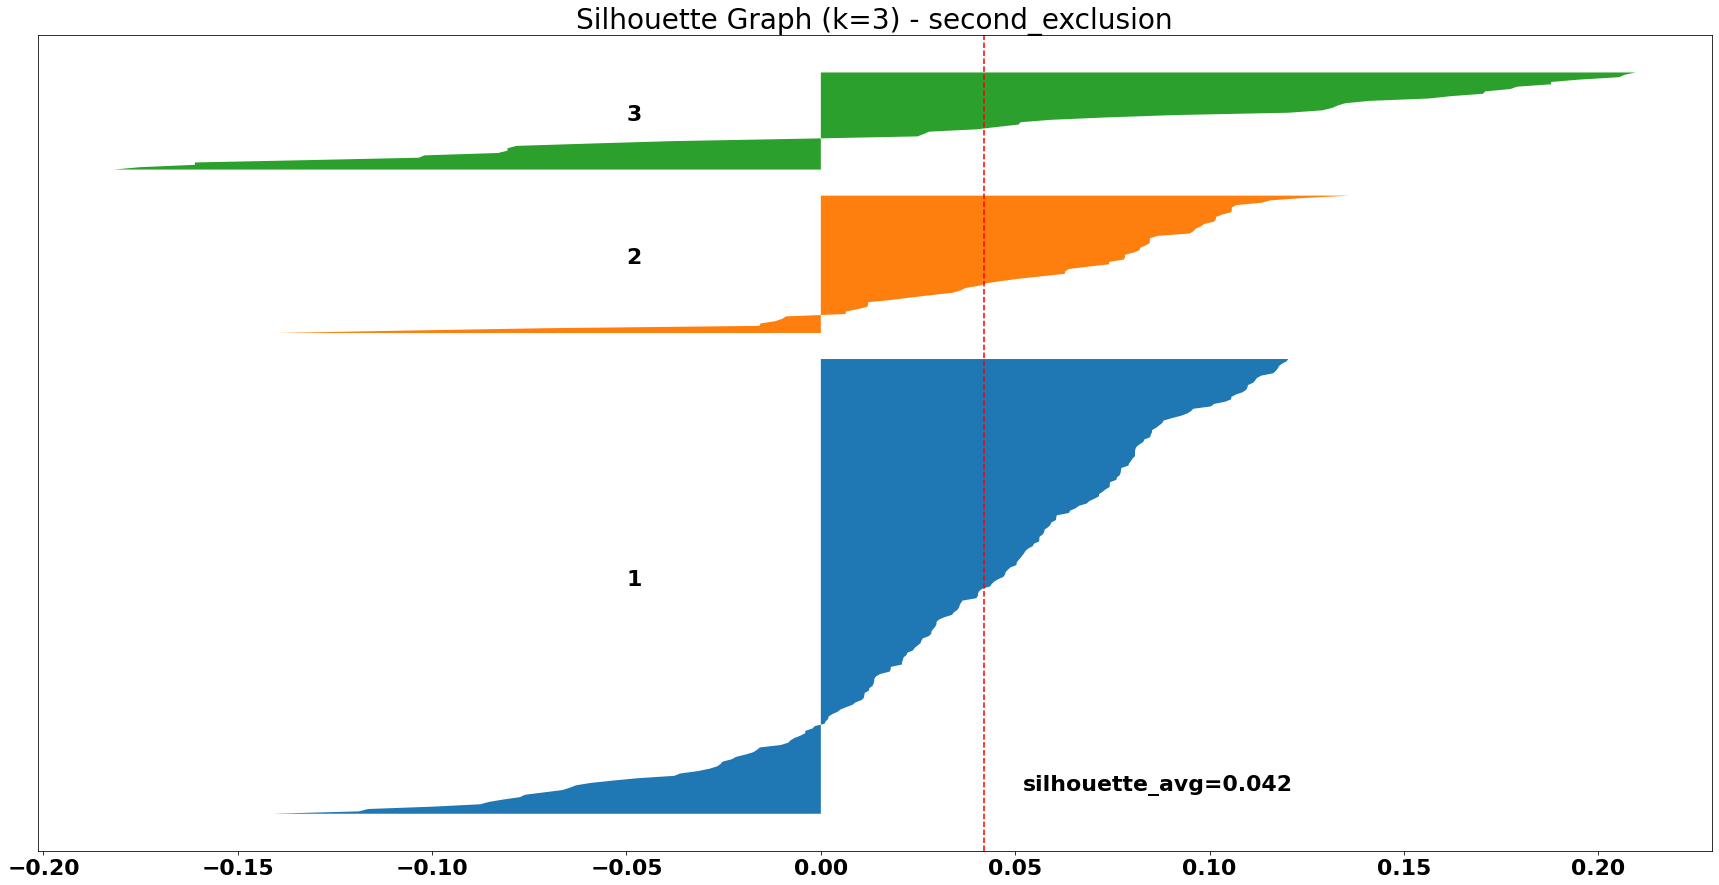

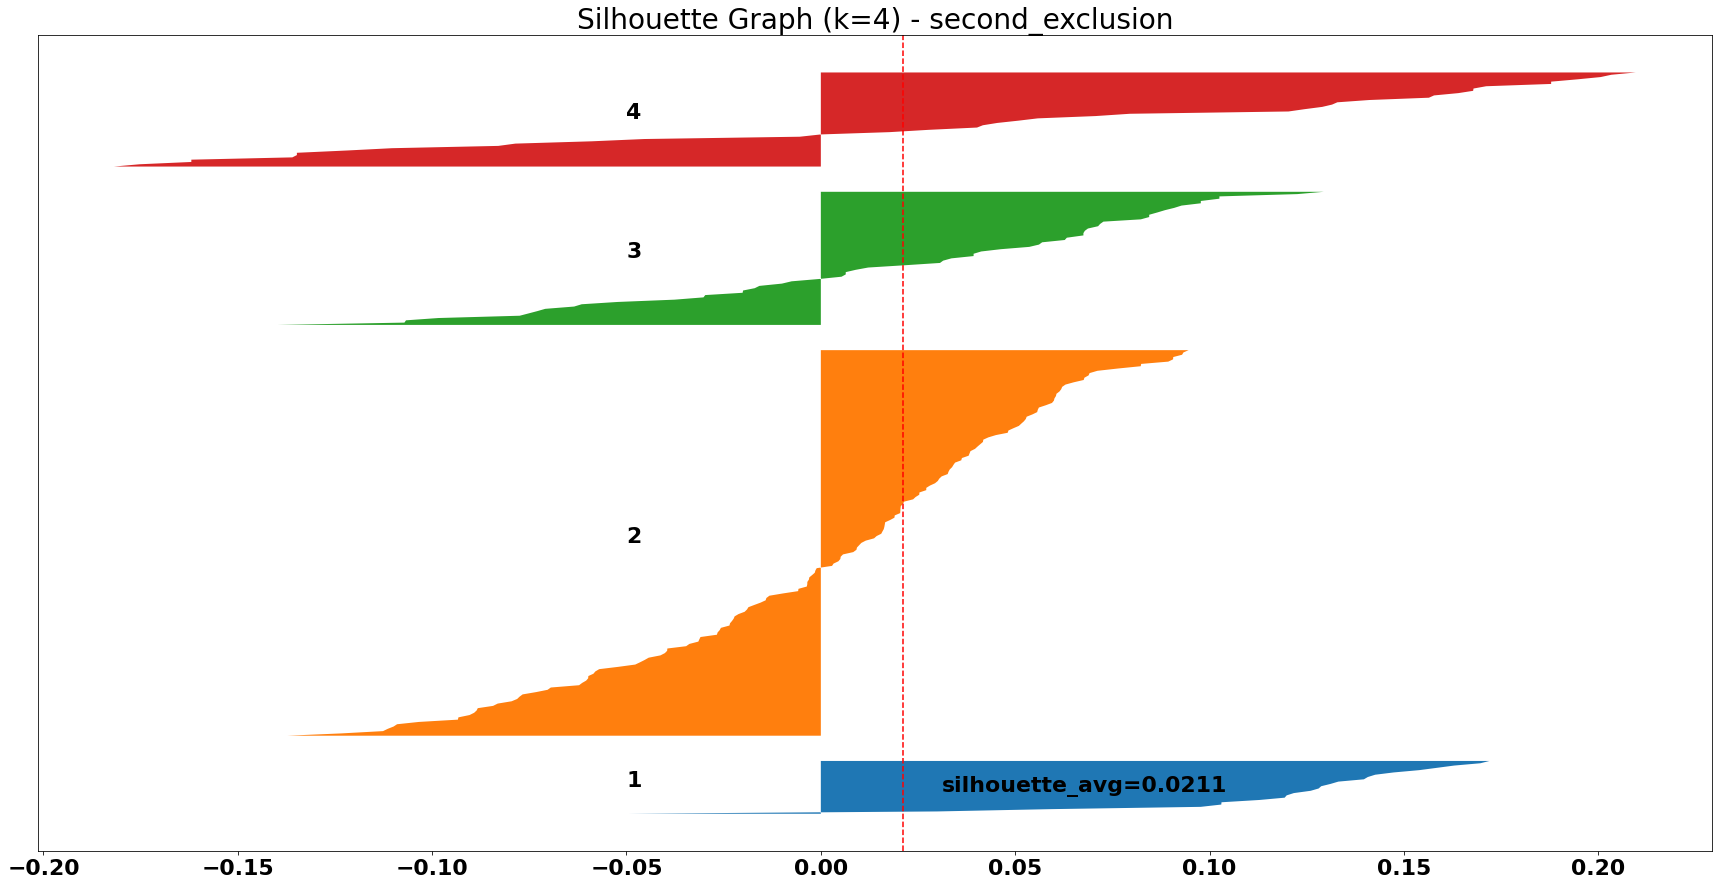

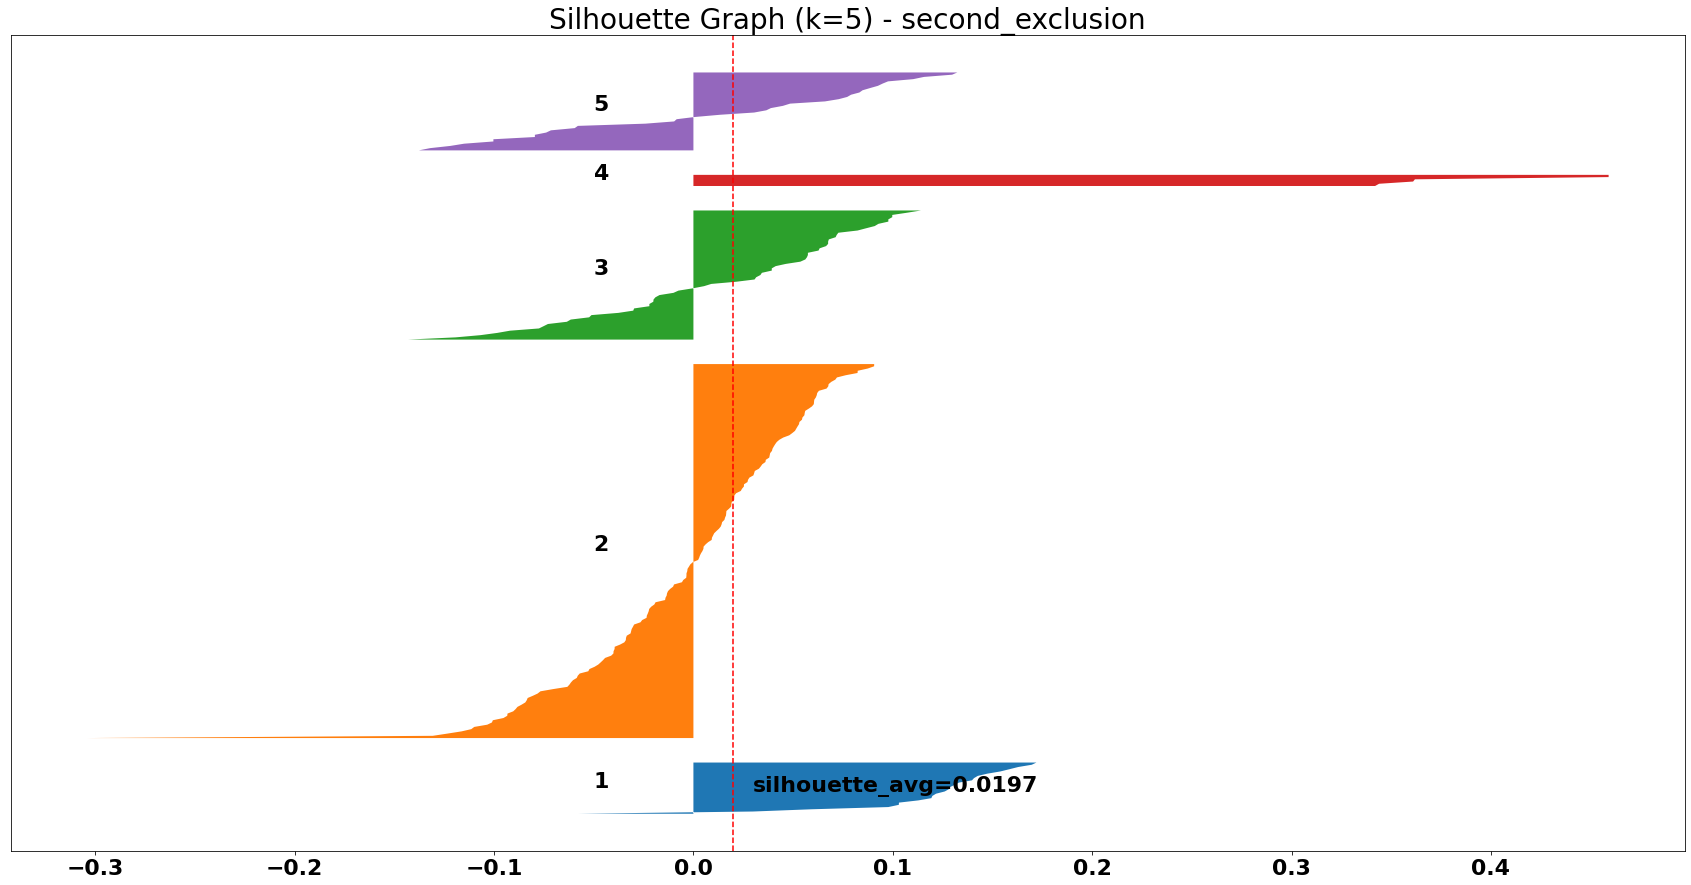

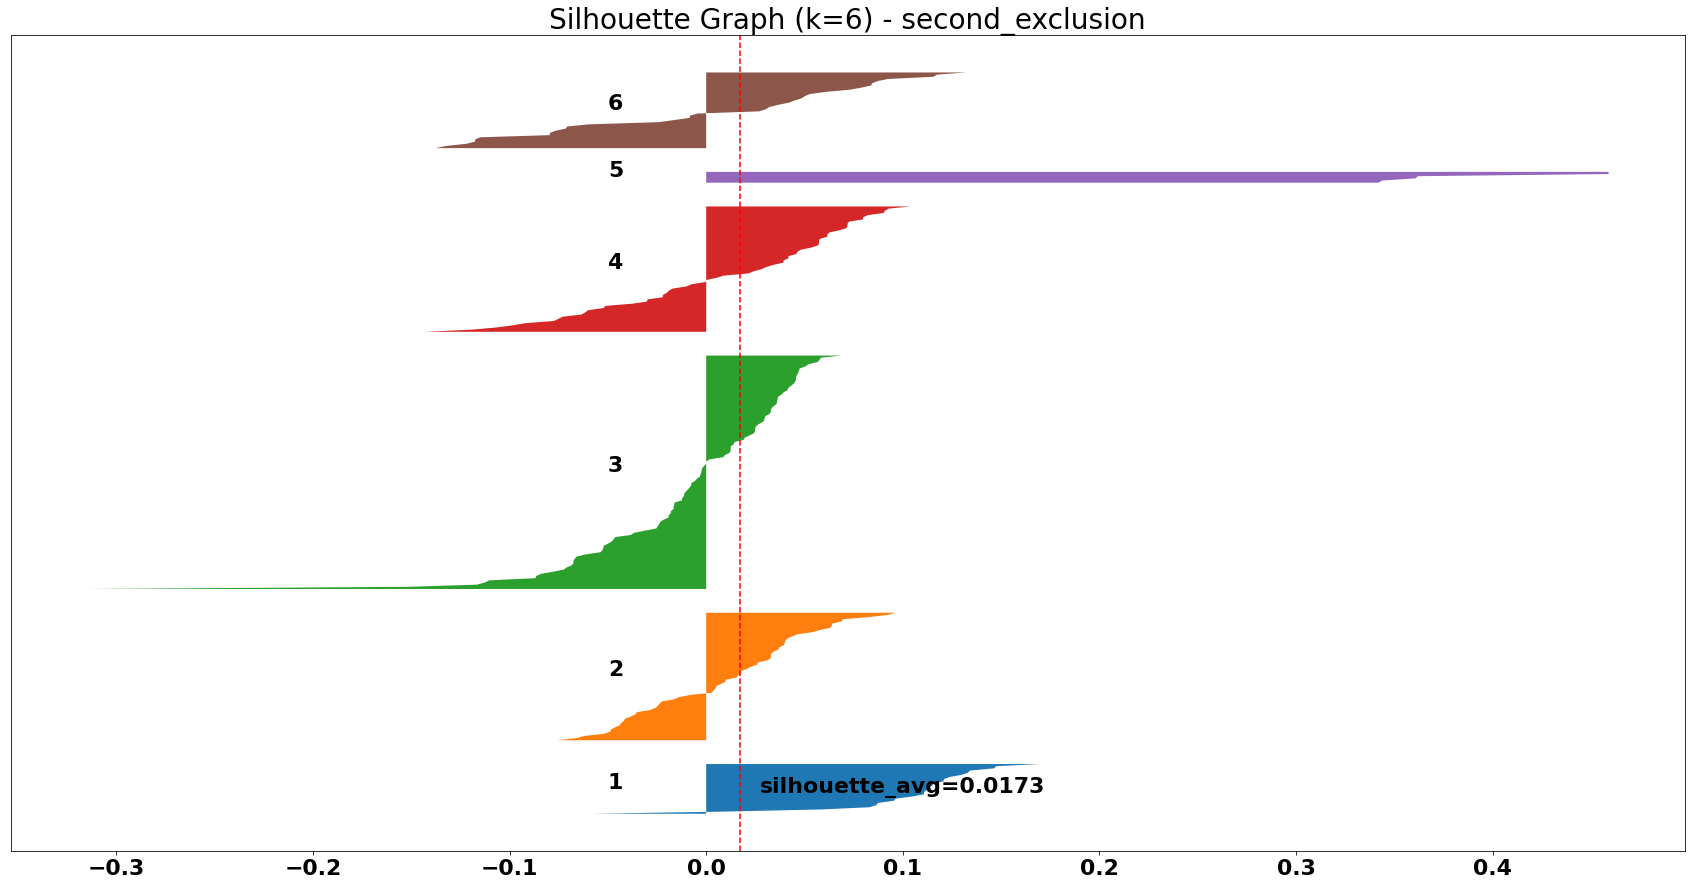

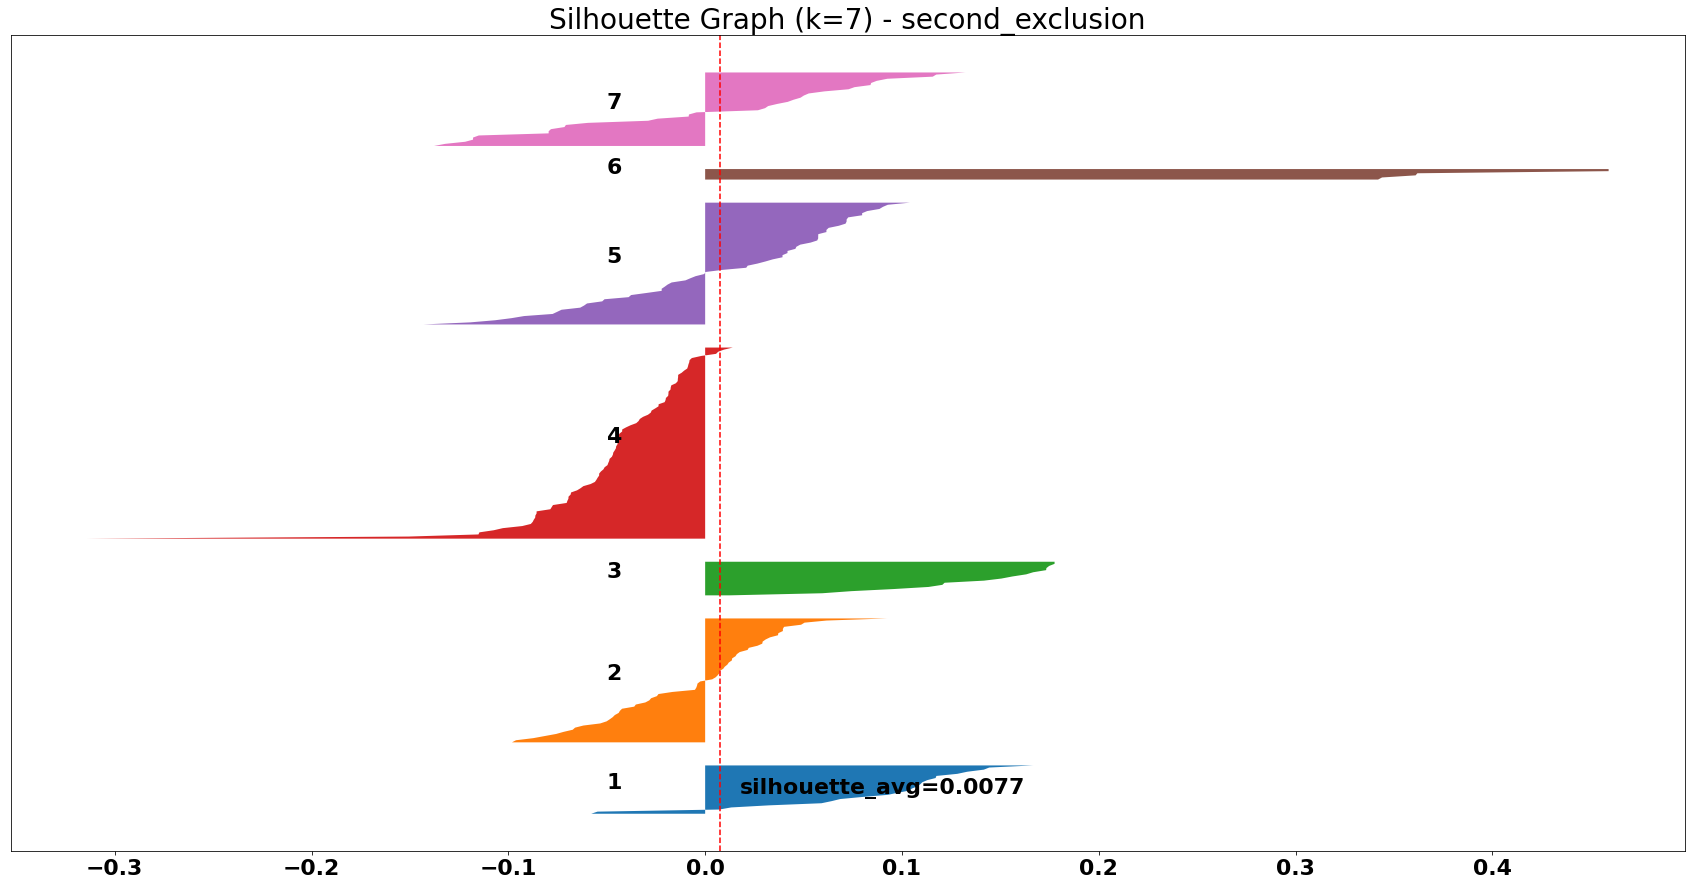

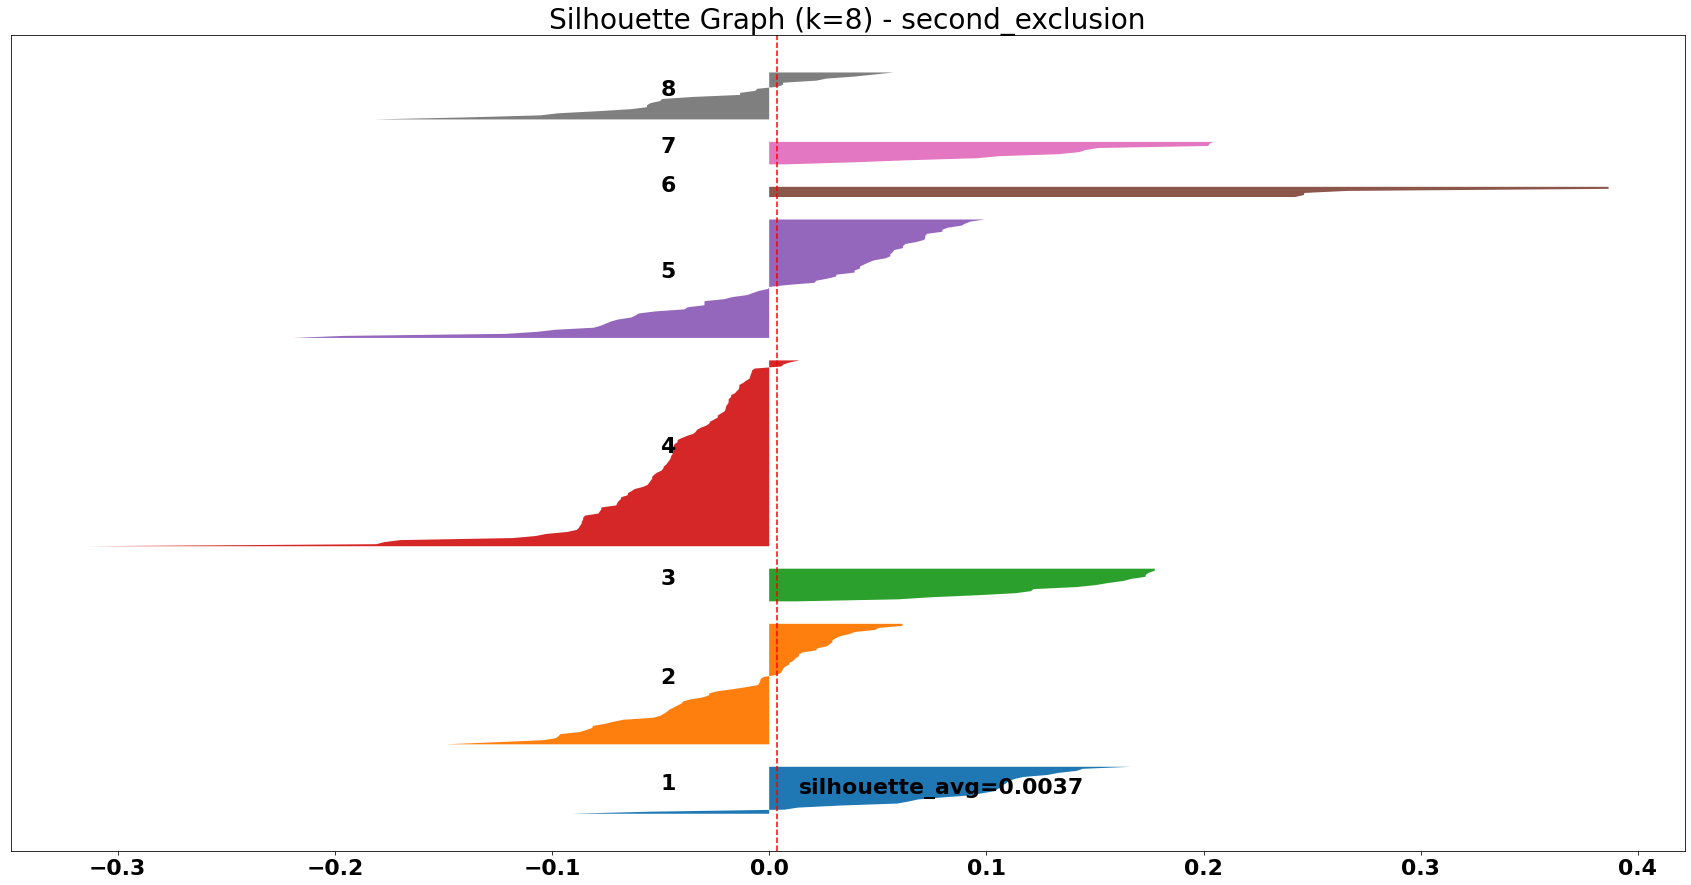

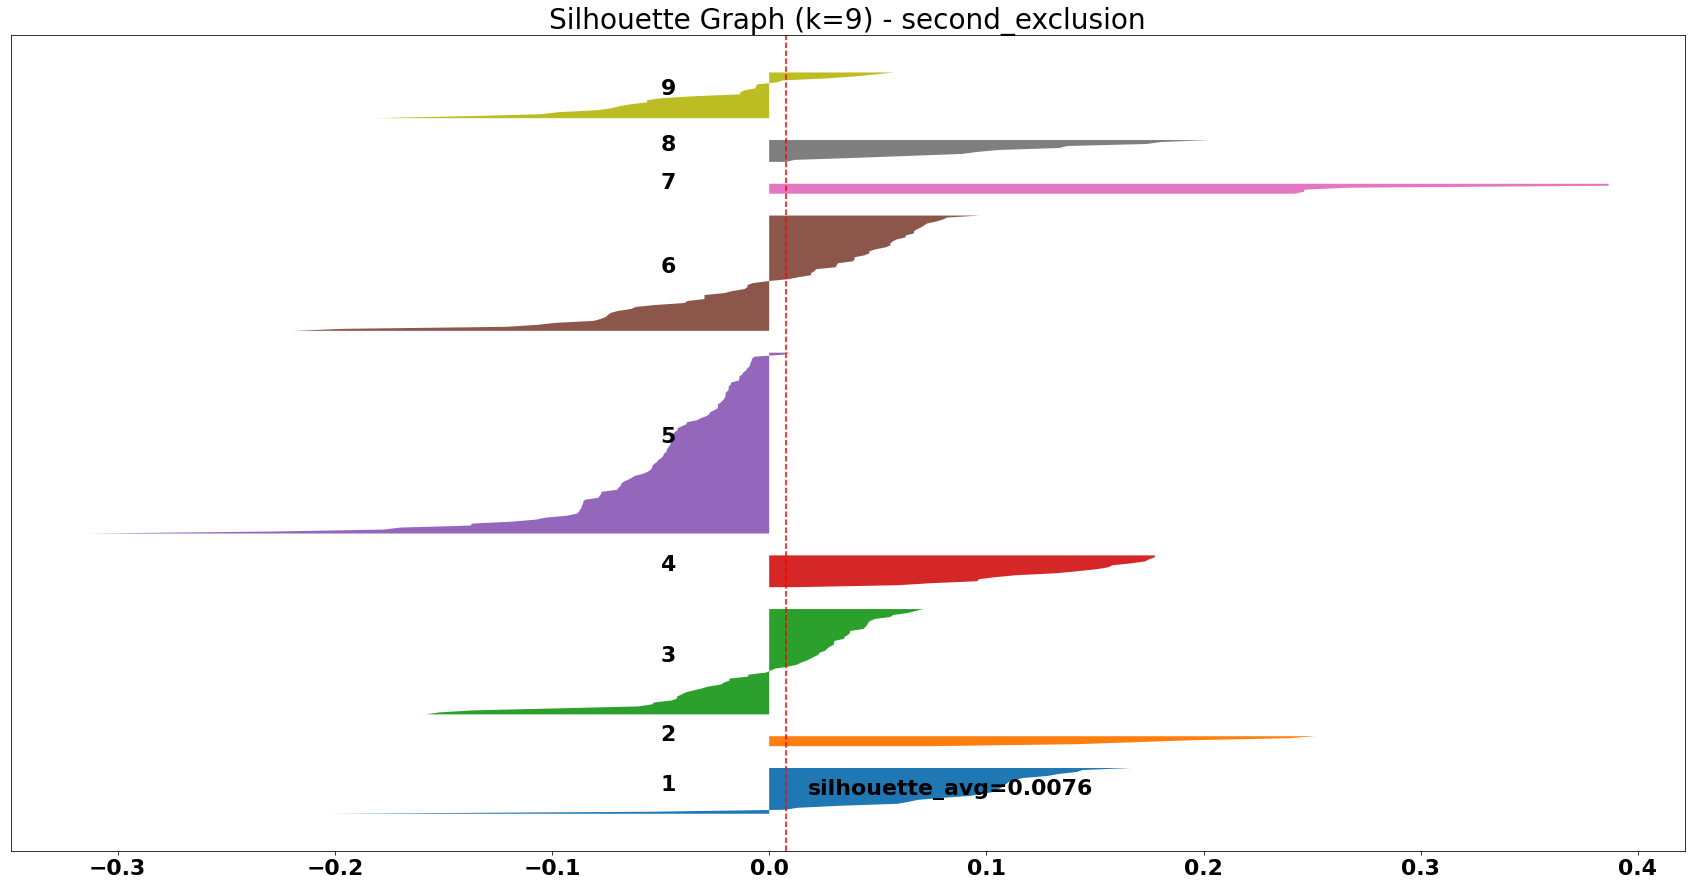

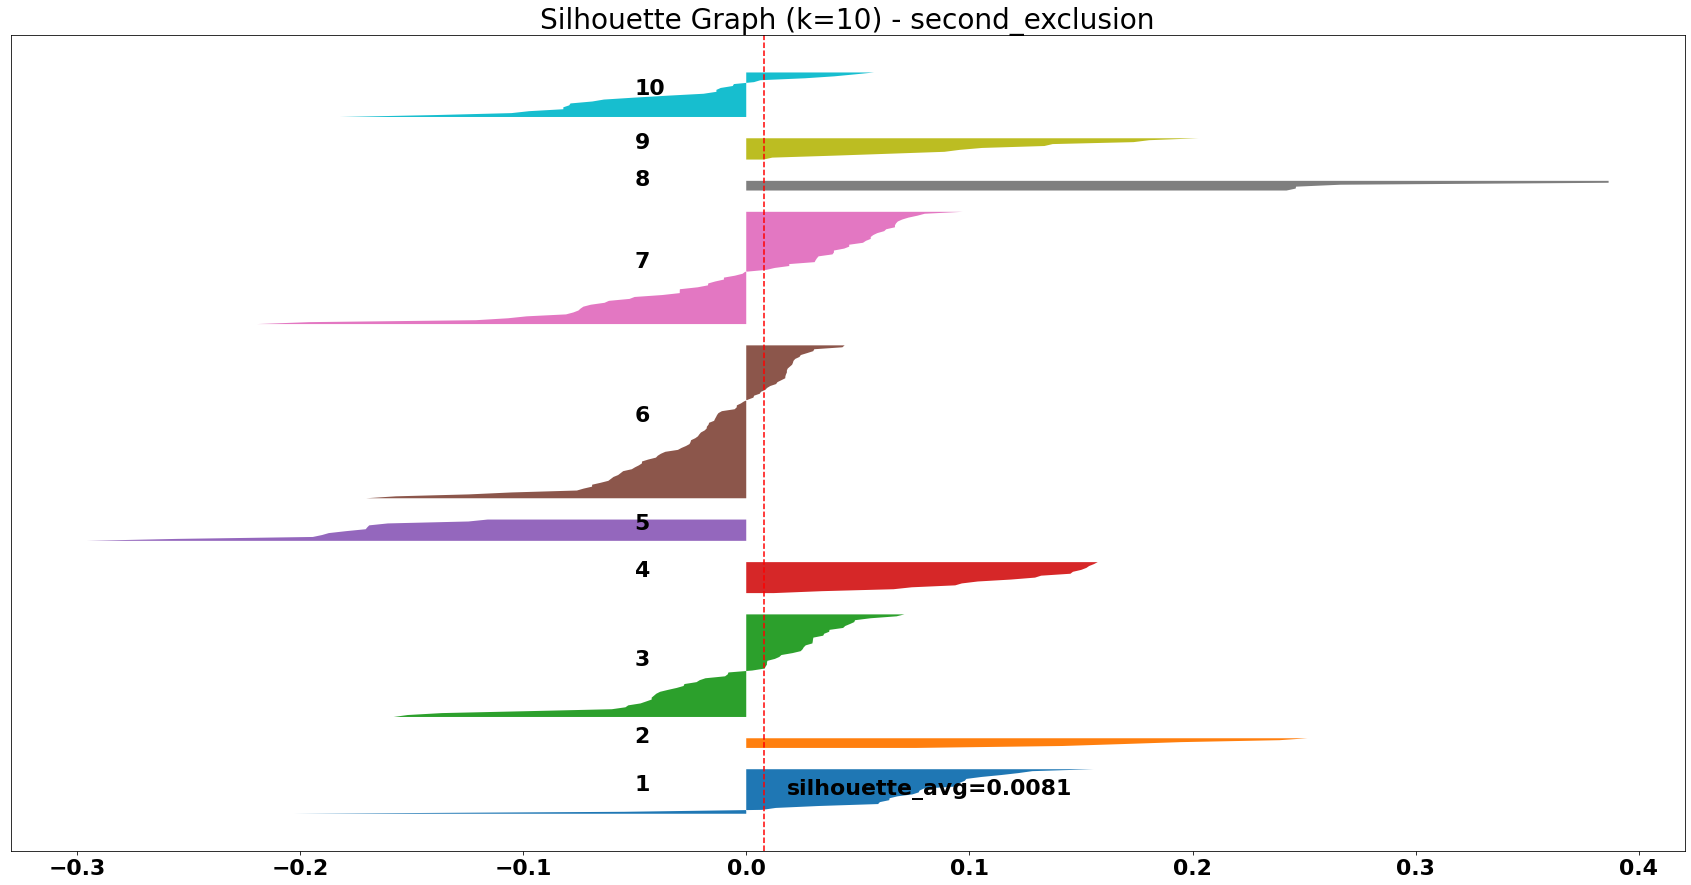

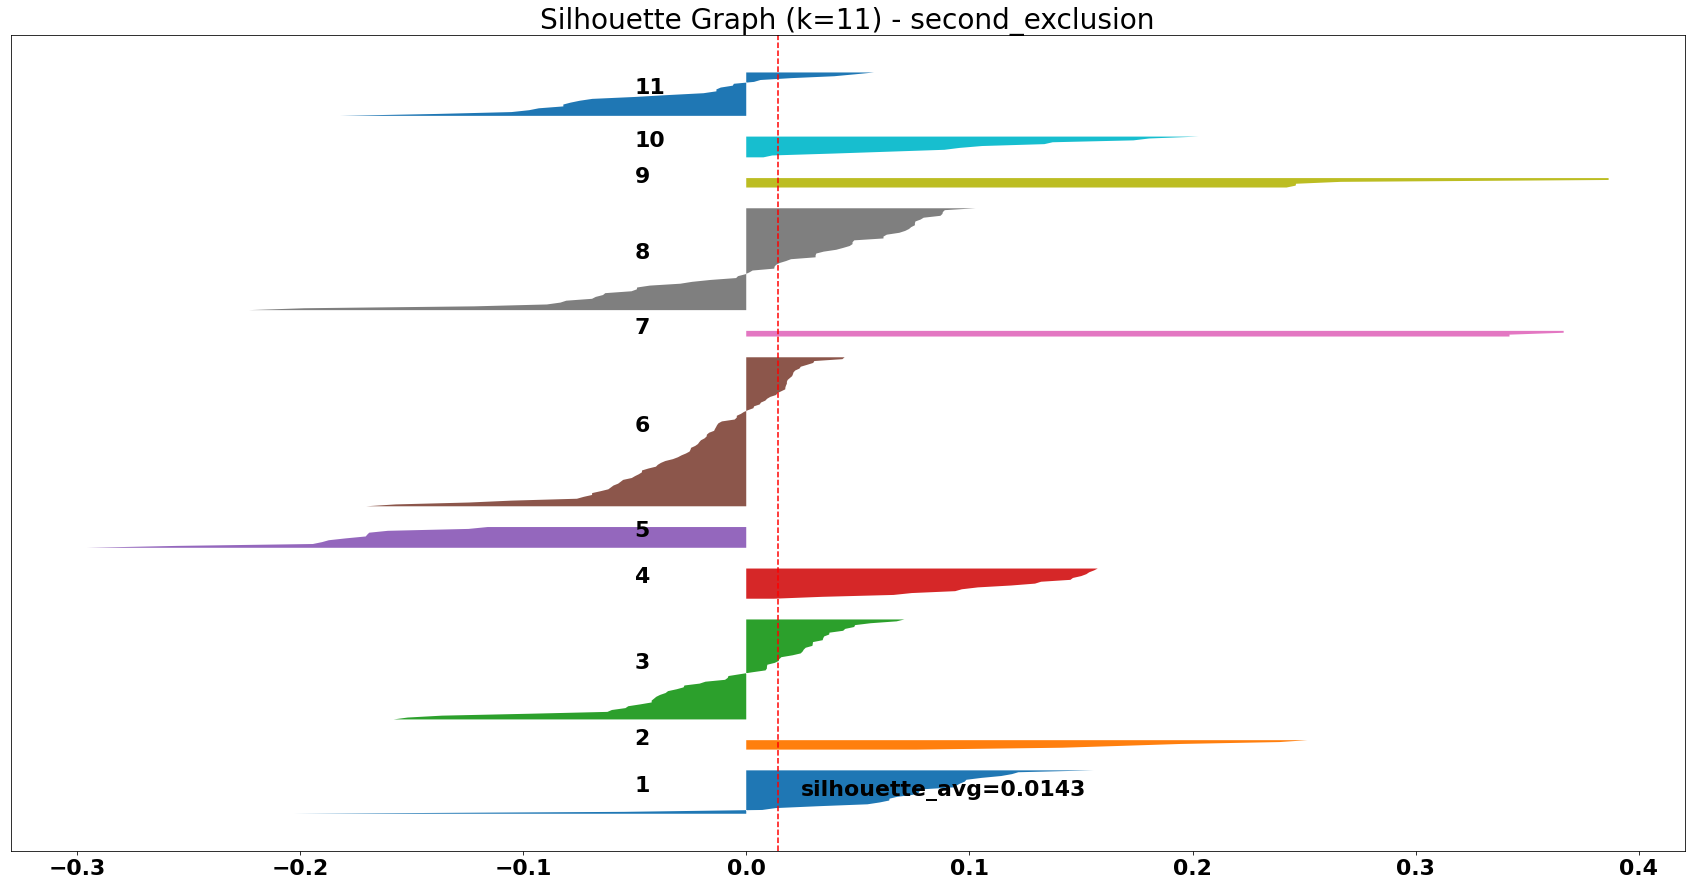

In [64]:
for i in range(2, 12):
    silhouette_evaluation(abstract_df, i, "second_exclusion", True)

### Extract Keywords

In [419]:
from gensim.sklearn_api import TfIdfTransformer

def sum_tfidf_scores(dct, corpus, n=None):
    total_score = {}
    
    for document in corpus:
        sorted_doc = sorted(document, key=(lambda x: (x[1], x[0])), reverse=True)
        for kwd_id, tfidf_score in sorted_doc[:n]:
            kwd = dct[kwd_id]
            stemmed_kwd = stem_text(stem_text(kwd))
            
            if kwd not in total_score:
                total_score[kwd] = 0
                
            total_score[kwd] += tfidf_score
            
    return sorted(total_score.items(), key=(lambda x: (x[1], x[0])), reverse=True)

def tfidf_keyword_scores(clusters, word_count=6, debug=False, exclude_words=[], **kwds):
    dct = corpora.Dictionary(preprocessed_abstracts)
    model = TfIdfTransformer(dictionary=dct)

    # train model on all documents
    all_docs_corpus = preprocessed_abstracts.apply(dct.doc2bow).tolist()
    model.fit(all_docs_corpus)

    # create corpus per cluster
    cluster_corpus = preprocessed_abstracts.groupby(clusters).apply(lambda x: [dct.doc2bow(abstract) for abstract in x])

    result = []

    for cluster_id, corpus in cluster_corpus.items():
        tfidf_corpus = model.transform(corpus)

        words_in_cluster = 0
        for keyword, score in sum_tfidf_scores(dct, tfidf_corpus):
            if keyword in exclude_words: continue
            result.append((cluster_id, keyword, score))
            words_in_cluster += 1
            
            if words_in_cluster == word_count:
                break

    return pd.DataFrame(result, columns=["cluster", "keyword", "score"])

In [349]:
def stemmed_keyword_mean_score(keywords):
    stemmed_scores = {}
    stemmed2kwd = {}
    
    for kwd, score in keywords:
        stemmed_kwd = stem_text(stem_text(kwd))
        
        if stemmed_kwd not in stemmed_scores:
            stemmed2kwd[stemmed_kwd] = kwd
            stemmed_scores[stemmed_kwd] = []

        stemmed_scores[stemmed_kwd].append(score)
        
    stemmed_scores = {stemmed2kwd[k]: np.mean(v) for (k, v) in stemmed_scores.items()} 
            
    return sorted(stemmed_scores.items(), key=(lambda x: (x[1], x[0])), reverse=True)

def text_rank_keyword_scores(clusters, word_count=6, debug=False, **kwds):
    result = []
    
    abstracts = preprocessed_abstracts if use_preprocessed else simple_preprocess_with_exclusion
    
    scored_keywords = abstracts.apply(" ".join)\
                               .apply(lambda s: re.sub(u"–", " ", s))\
                               .groupby(clusters)\
                               .apply(". ".join)\
                               .apply(lambda x: keywords(x, scores=True, **kwds))
    

    for group, kw_list in scored_keywords.iteritems():
        stemmed_keywords_seen = set([])
        
        for keyword, score in kw_list:
            if len(stemmed_keywords_seen) == word_count:
                break
                
            stemmed_keyword = stem_text(stem_text(keyword))
            
            if debug:
                print(", ".join([keyword, stemmed_keyword, str(score), str(stemmed_keywords_seen)]))
            
            if stemmed_keyword not in stemmed_keywords_seen:
                stemmed_keywords_seen.add(stemmed_keyword)
                result.append((group, keyword, score))
            
    return pd.DataFrame(result, columns=["cluster", "keyword", "score"])

In [416]:
def plot_cluster_keywords(X, n_clusters, name, clustering_func=text_rank_keyword_scores, **kwds):
    clustering_func_name = "text_rank" if clustering_func == text_rank_keyword_scores else "tfidf"
    
    X_scores = clustering_func(cluster(X, n_clusters), **kwds)
    
    fig, axes = plt.subplots(nrows=n_clusters)
        
    fig.suptitle(f"{name} {n_clusters}", fontsize=35)
    fig.set_figheight(50)
    
    for i, ax in enumerate(axes):
        cluster_num = i + 1
        
        sns.barplot(
            x='keyword',  
            y='score',  
            data=X_scores[X_scores['cluster'] == cluster_num],
            ax=ax
        )

        ax.set_title(f"cluster={cluster_num}")
        ax.set_xlabel(None)
        ax.tick_params(axis='x', labelsize=40)
        
    plt.subplots_adjust(hspace=n_clusters*0.2)
    
    fig.savefig(f'plots/{name}/keywords_{n_clusters}_{clustering_func_name}_{"_".join(f"{k}{v}" for (k, v) in kwds.items() if k != "debug")}.pdf', format='pdf')

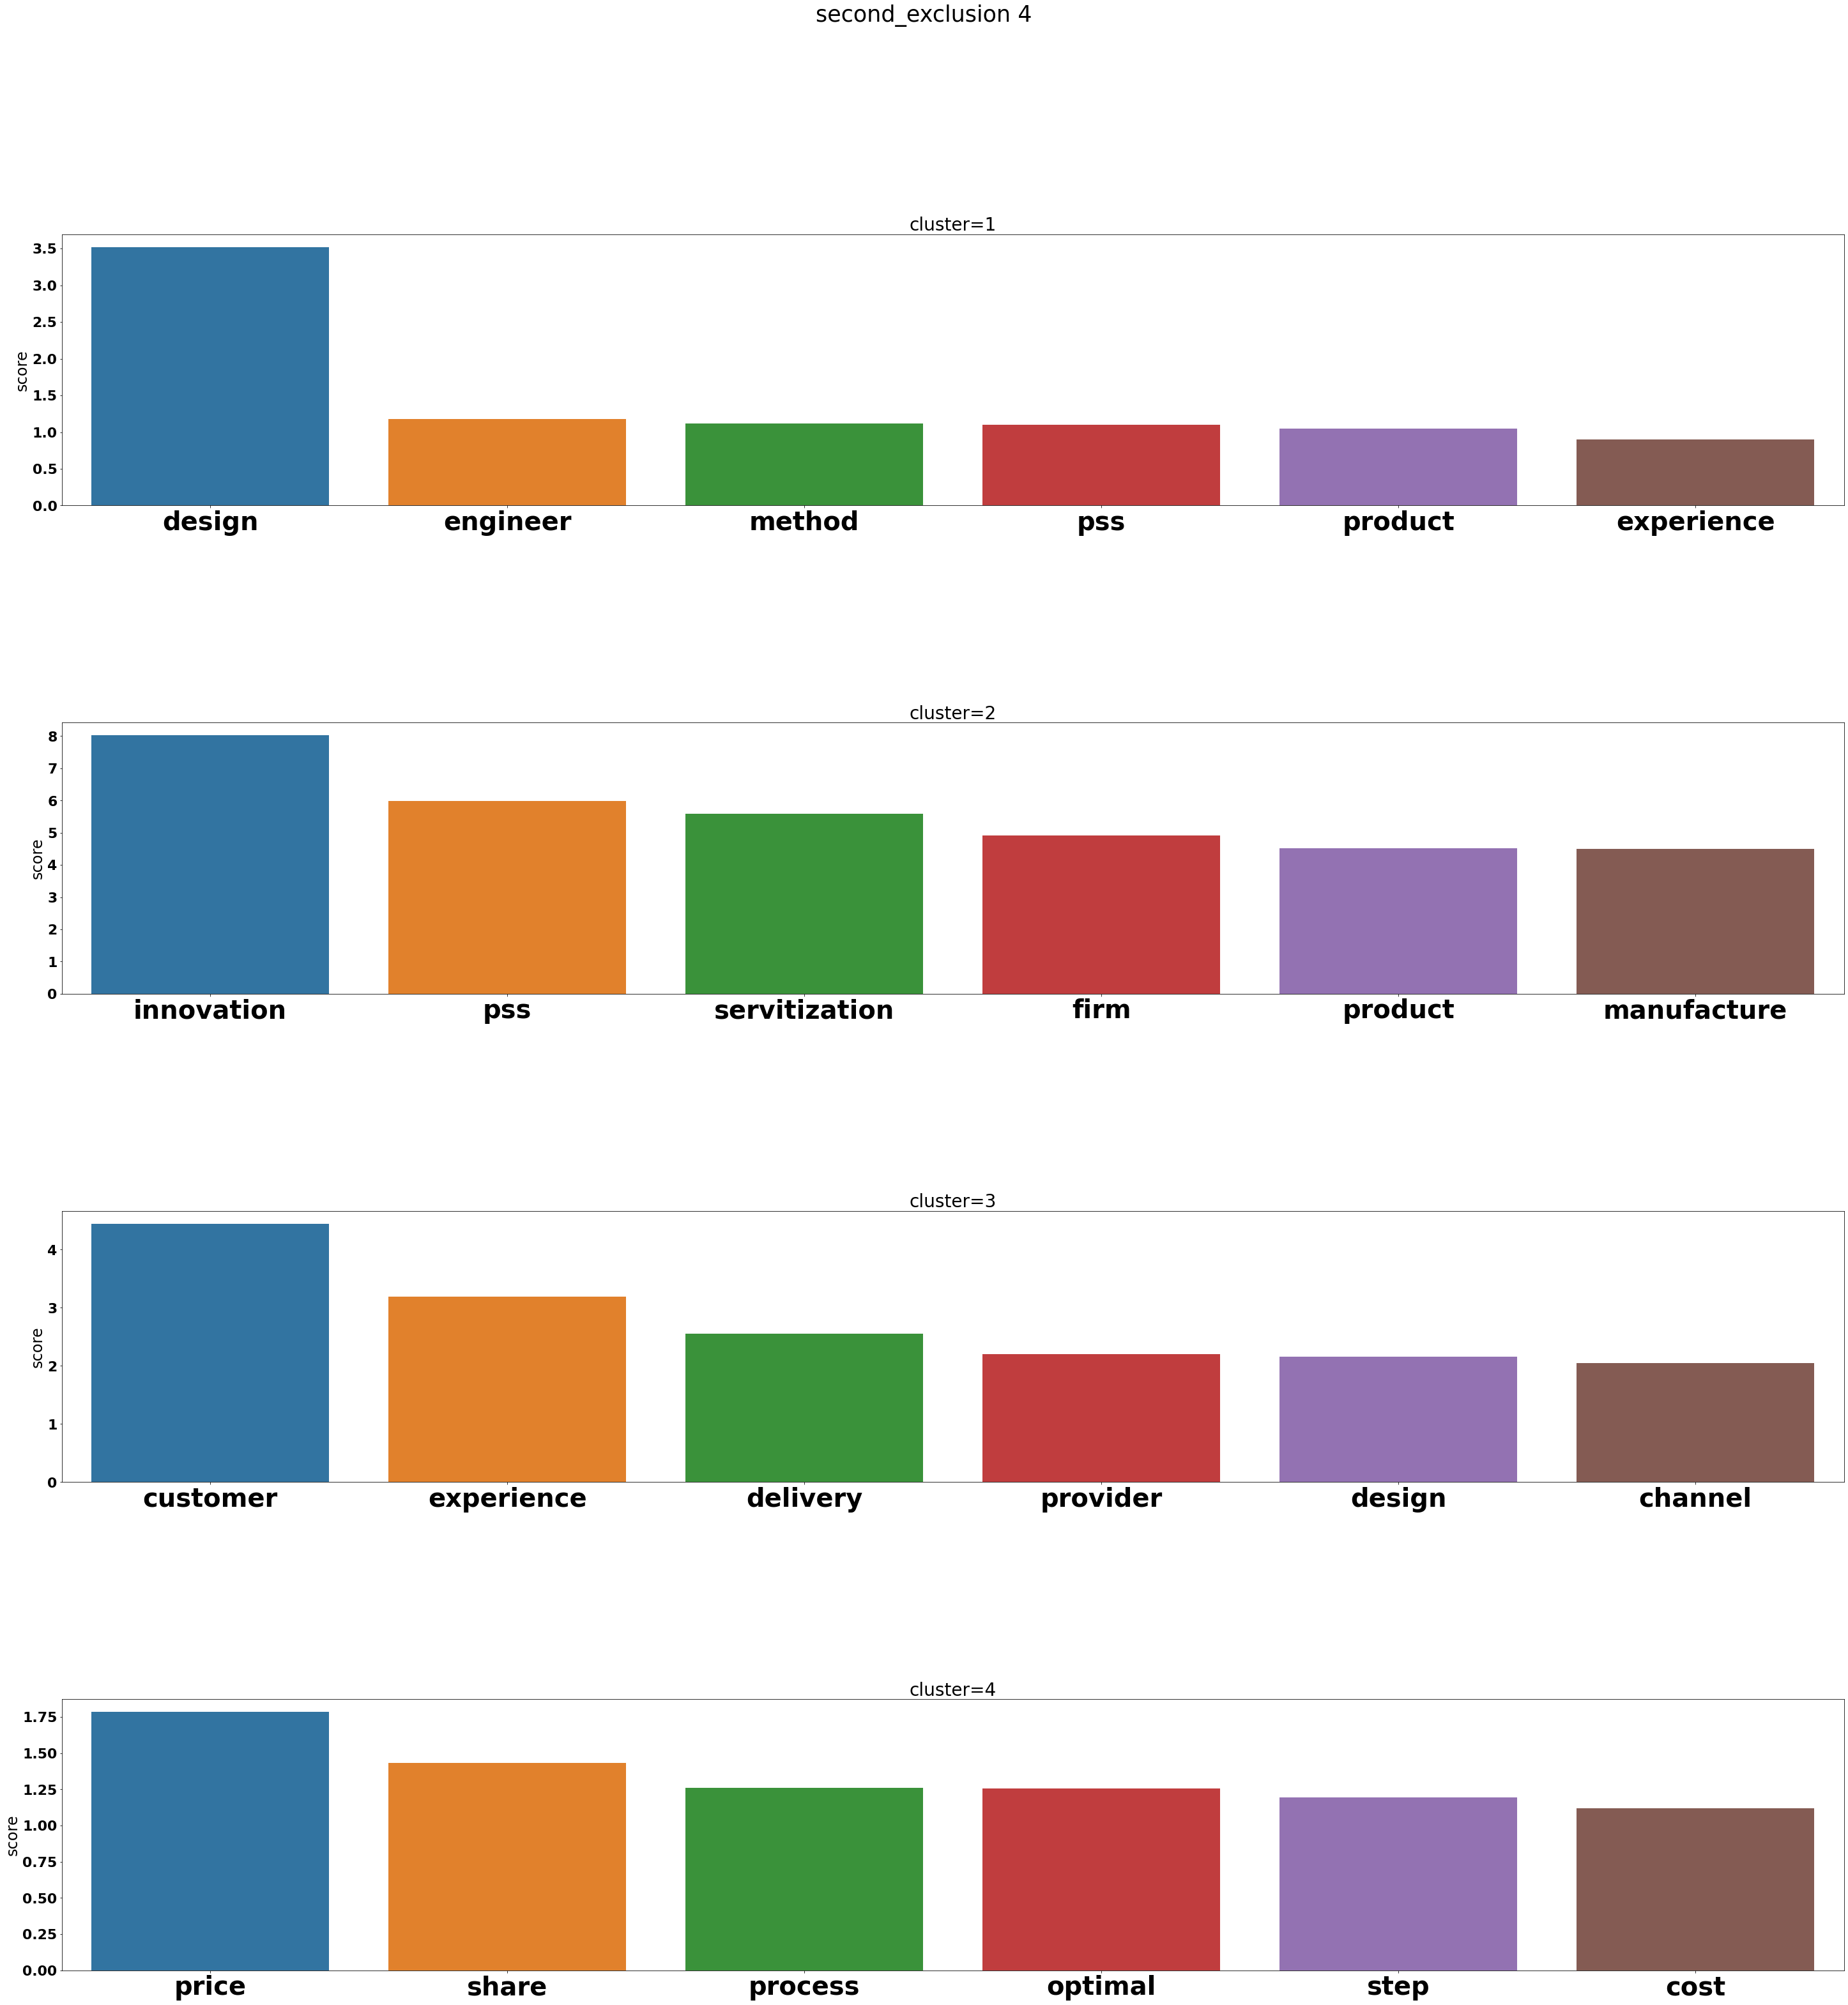

In [417]:
plot_cluster_keywords(abstract_df, 4, "second_exclusion", clustering_func=tfidf_keyword_scores)

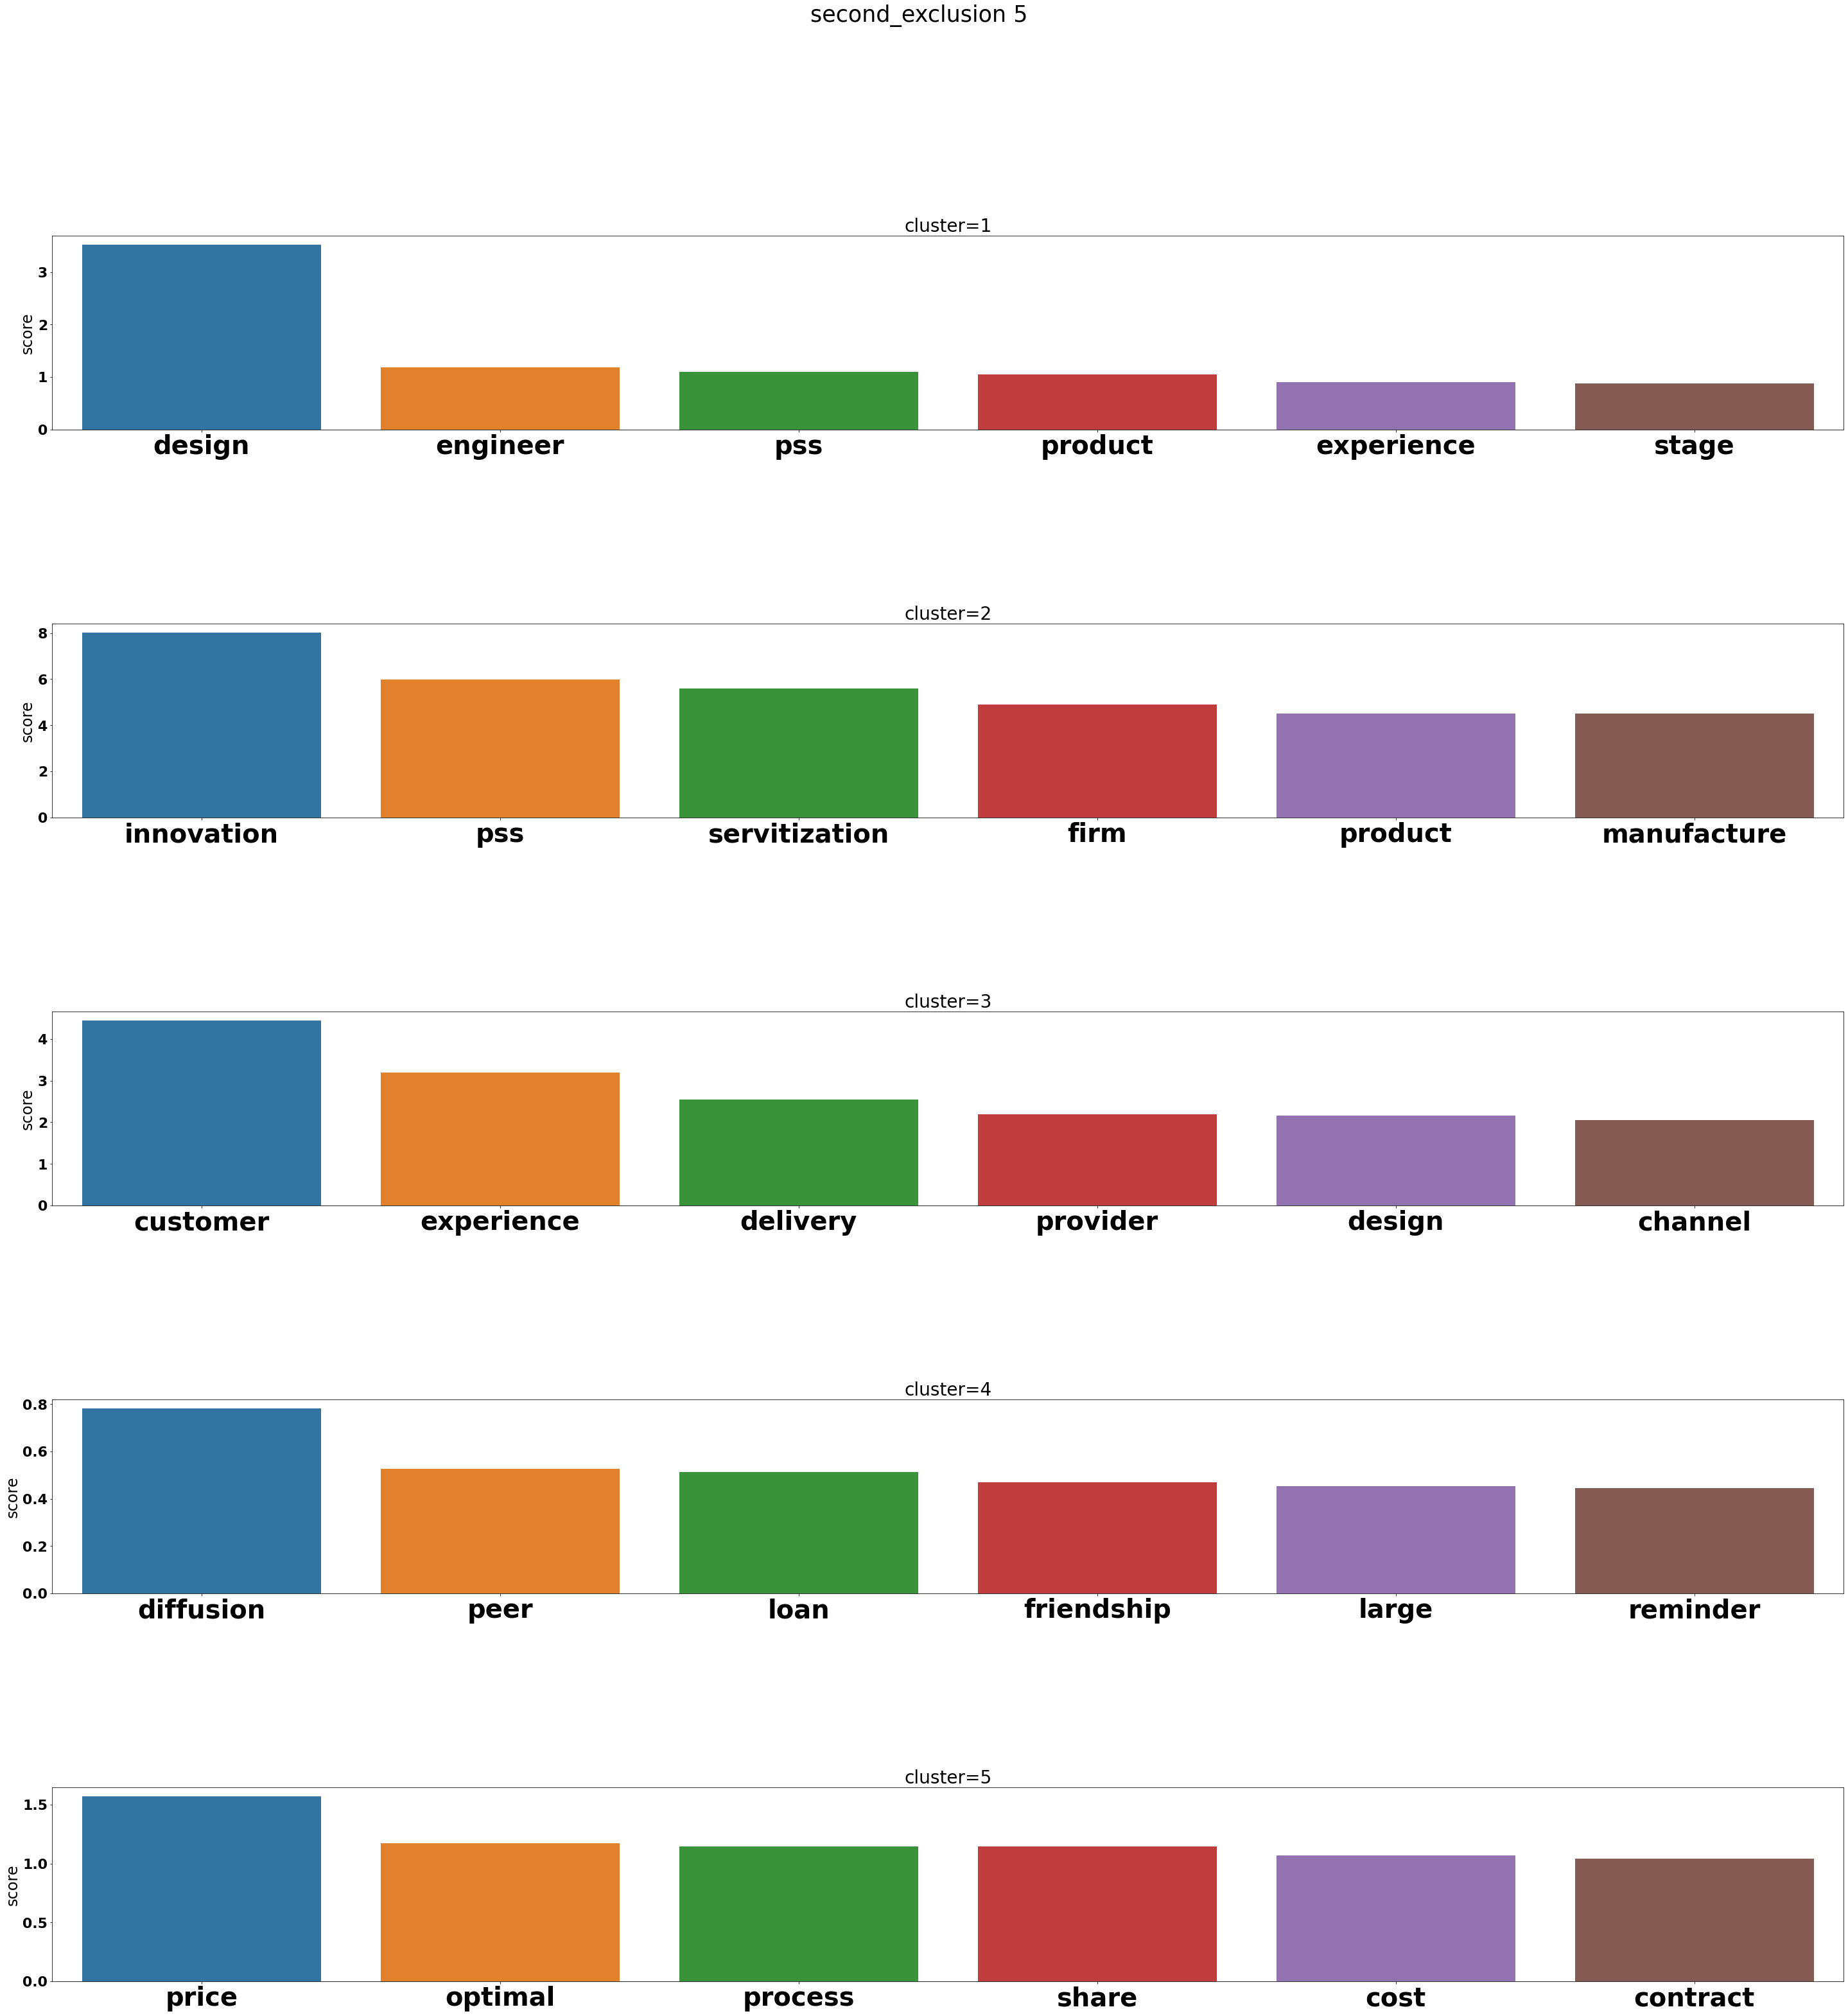

In [421]:
plot_cluster_keywords(abstract_df, 5, "second_exclusion", clustering_func=tfidf_keyword_scores, exclude_words=["step", "method"])

### Save Results

In [174]:
df["cluster_4"] = cluster(abstract_df, 4)
df["cluster_5"] = cluster(abstract_df, 5)

In [175]:
df.to_csv('results/second_exclusion_clusters.csv')

## Alternatives

### Topic Modeling

In [76]:
dct = corpora.Dictionary(preprocessed_abstracts)
corpus = [dct.doc2bow(abstract) for abstract in preprocessed_abstracts]
lda = LdaMulticore(corpus, id2word=dct, num_topics=6)

In [77]:
lda.show_topics()

[(0,
  '0.018*"innovation" + 0.014*"design" + 0.012*"model" + 0.010*"base" + 0.008*"product" + 0.007*"management" + 0.007*"new" + 0.007*"technology" + 0.007*"customer" + 0.007*"system"'),
 (1,
  '0.025*"customer" + 0.012*"process" + 0.011*"design" + 0.010*"model" + 0.009*"innovation" + 0.009*"product" + 0.008*"servitization" + 0.007*"experience" + 0.006*"busines" + 0.006*"provide"'),
 (2,
  '0.017*"design" + 0.017*"innovation" + 0.015*"process" + 0.012*"customer" + 0.008*"product" + 0.007*"value" + 0.007*"company" + 0.006*"technology" + 0.005*"model" + 0.005*"ps"'),
 (3,
  '0.020*"innovation" + 0.013*"product" + 0.012*"design" + 0.012*"customer" + 0.011*"firm" + 0.011*"process" + 0.009*"value" + 0.009*"model" + 0.008*"busines" + 0.008*"performance"'),
 (4,
  '0.020*"design" + 0.017*"customer" + 0.013*"innovation" + 0.009*"experience" + 0.007*"process" + 0.007*"network" + 0.006*"base" + 0.006*"provider" + 0.005*"develop" + 0.005*"provide"'),
 (5,
  '0.017*"customer" + 0.016*"innovation"